# Wstęp

Celem projektu jest klasyfikacja zdjęć względem lokacji, w jakich zostały wykonane.

# Struktura projektu

Role poszczególnych katalogów są następujące:
* katalog `base` zawiera klasy bazowe dla modeli oraz trenerów.
* katalog `models` zawiera poszczególne klasy modeli. Klasy te powinny dziedziczyć po klasie `BaseModel`.
* katalog `trainers` zawiera klasy trenerów. Powinny one dziedziczyć po klasie `BaseTrainer`.
* katalog `configs` zawiera pliki konfiguracyjne.
* katalog `scripts` zawiera dodatkowe skrypty.
* katalog `data` zawiera informacje o zbiorach danych, jest też domyślną lokalizacją pobierania obrazów.

## Konfiguracja

W projekcie wykorzystywałem pliki konfiguracyjne w formacie YAML. Pliki te podzielone są na następujące sekcje:
* `devices` zawiera ustawienia związane z urządzeniami GPU
* `data` zawiera ustawienia związane z wczytywaniem danych
* `model` wskazuje klasę modelu oraz wszystkie potrzebne jej ustawienia (np. wymiary warstw, dropout, learning rate)
* `trainer` wskazuje klasę trenera oraz wszystkie potrzebne jej ustawienia (np. liczbę epok)

Dokładniejszy opis poszczególnych parametrów znajduje się w pliku `configs/base_config.yml`

## Wczytywanie danych

Dane wczytywane są z rozpakowanych plików ze zdjęciami, z zachowaniem oryginalnej struktury katalogów. Informacje o poszczególnych zbiorach (treningowy, walidacyjny, testowy) wczytywane są z wygenerowanych wcześniej plików csv. Pliki te zawierają dwie kolumny: ścieżkę do pliku oraz etykietę (wygenerowaną na podstawie ścieżki). Taki format umożliwia wygodne wczytywanie danych za pomocą metody `ImageDataGenerator.flow_from_dataframe`, po uprzednim wczytaniu pliku do obiektu `pandas.DataFrame`.

Dostarczone pliki csv definiują podział całego zbioru danych na części treningową, walidacyjną i testową. Dostępny jest także skrypt `create_subsets.py` umożliwiający tworzenie losowych podzbiorów danych, co umożliwia trenowanie na części zbioru treningowego. Działanie procesu wczytywania danych zaprezentowane jest poniżej.

In [1]:
from utils import config, data
import matplotlib.pyplot as plt

cfg = config.get_config("configs/deep_network.yml")
train_loader = data.get_train_valid_loaders(cfg)["train"]

Found 38064 validated image filenames belonging to 397 classes.
Found 8156 validated image filenames belonging to 397 classes.


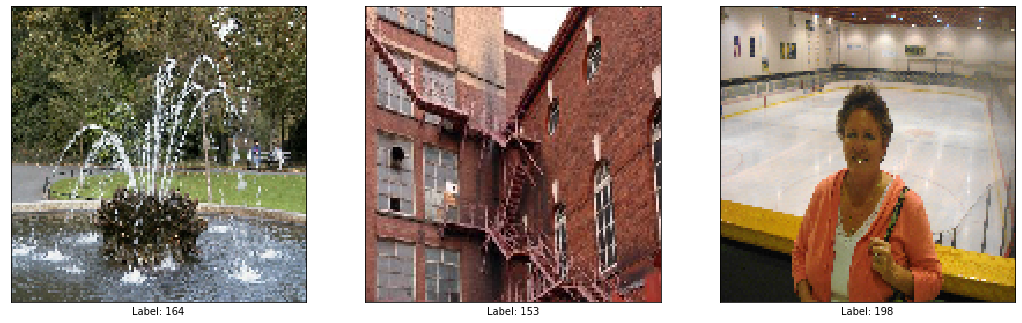

In [2]:
x, y = next(train_loader)
fig, axes = plt.subplots(figsize=(18, 6), ncols=3, facecolor="white")
for i, ax in enumerate(axes):
    ax.imshow(x[i, :, :, :] / 255.)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(f"Label: {y[i].argmax()}")

## Konstrukcja modeli

Aby zdefiniować nowy model należy utworzyć plik zawierający klasę dziedziczącą po klasie `BaseModel` oraz nadpisującą metodę `build_model`. We wszystkich zaimplementowanych przeze mnie modelach metoda ta budowała instancję klasy `keras.models.Sequential`.

## Trenowanie modeli

Do trenowania modeli służą klasy trenerów. Klasa `BaseTrainer`, realizuje trenowanie z ustalonym parametrem learning rate oraz logowanie do tensorboard. Jest to też klasa bazowa dla pozostałych implementacji trenerów. W celu rozszerzenia funkcjonalności należy skorzystać z funkcji oferowanych przez moduł `keras.callbacks`, nadpisując metodę `init_callbacks` klasy `BaseTrainer`.

# Zaimplementowane klasy

## Modele

### `DenseModel`

Model głębokiej sieci neuronowej, tworzony na podstawie informacji zawartych w pliku konfiguracyjnym. Składa się on z ciągu warstw liniowych z aktywacjami ReLU, z opcjonalnymi warstwami `Dropout` występującymi po każdej warstwie oprócz wyjściowej. Liczba oraz wymiary ukrytych warstw definiowane są poprzez parametr `model.hidden_dims` w pliku konfiguracyjnym.

### `SimpleConvModel`

Pomniejszona wersja popularnej architektury VGG16. Sieć składa się z ciągu bloków warstw konwolucyjnych, po których występuje jedna ukryta warstwa liniowa. W każdym bloku znajdują się dwie warstwy konwolucyjne o tej samej liczbie kanałów wyjściowych oraz wymiarze jądra $3\times3$ oraz warstwa `MaxPool` o wymiarze jądra $2\times2$. Opcjonalnie, po każdej warstwie konwolucyjnej może znajdować się warstwa `Dropout`. Liczba oraz wymiary warstw liniowych definiowane są tak samo jak w przypadku poprzedniego modelu.

## Klasy trenujące

### `BaseTrainer`

Implementuje podstawowe funkcjonalności, tj. wywoływanie metody `model.fit` oraz logowanie do Tensorboard.

### `ReduceLROnPlateauTrainer`

Wprowadza następujące dodatkowe funkcjonalności względem klasy `BaseTrainer`:
* Zmniejszanie wartości learning rate w przypadku braku postępów podczas uczenia
* Logowanie wartości learning rate do Tensorboard
* Zapisywanie najlepszego modelu po każdej epoce

### `LRSchedulerTrainer`

Wprowadza następujące dodatkowe funkcjonalności względem klasy `BaseTrainer`:
* Możliwość zdefiniowania zmian wartości learning rate po określonych epokach
* Logowanie wartości learning rate do Tensorboard
* Zapisywanie najlepszego modelu po każdej epoce

# Wyniki

Poniżej przedstawiam wyniki ważniejszych eksperymentów jakie przeprowadziłem. W nawisach obok klasy modelu podałem wymiary wyjściowe ukrytych warstw liniowych. We wszystkich eksperymentach używałem klasy ReduceLROnPlateauTrainer.

| Nr | Model | Użyta część zbioru treningowego | Learning rate | Liczba epok | Dropout | Weight decay | Batch size | Rozmiar wejścia | Dokł. na zbiorze testowym |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1. | DeepModel [1024, 1024] | 50% | 1e-3, 1e-4 | 10 | 0.3 | 0 | 64 | 128x128 | 2.2% |
| 2. | DeepModel [2048, 1024] | 50% | 1e-3, 1e-4 | 10 | 0.3 | 0 | 64 | 64x64 | 2.2% |
| 3. | SimpleConvModel [1024] | 50% | 1e-3, 1e-4 | 8 | brak | 0 | 32 | 128x128 | 16.4% |
| 4. | SimpleConvModel [1024] | 50% | 1e-3, 1e-4 | 20 | 0.2 dla warstw konwolucyjnych, 0.5 dla liniowych | 0 | 32 | 128x128 | 13.6% |
| 5. | SimpleConvModel [1024] | 50% | 1e-3, 1e-4, 1e-5 | 33 | 0.2 dla warstw konwolucyjnych, 0.5 dla liniowych | 1e-3 | 32 | 128x128 | 21.8% |
| 6. | SimpleConvModel [1024] | 100% | 1e-3, 1e-4 | 30 | 0.2 dla warstw konwolucyjnych, 0.5 dla liniowych | 1e-3 | 32 | 128x128 | 24.6% |

Eksperyment nr 3. przerwałem z powodu silnego przetrenowania sieci - skuteczność na zbiorze treningowym przekroczyła 90% przy skuteczności na zbiorze walidacyjnym poniżej 20%.

# Wnioski

Klasyfikacja scen okauje się być trudnym zadaniem, z którym nie poradziły sobie klasyczne sieci neuronowe. Niemniej jednak sieci konwolucyjne wydają się być w stanie je rozwiązać. Ważna jest jednak odpowiednia regularyzacja modeli, aby zapobiec zjawiskom takim jak przetrenowanie. Eksperymenty wykazały dużą skuteczność odpowiednio dobranej regularyzacji L2.